<a href="https://colab.research.google.com/github/duttapratikcsc/NPTEL/blob/master/Regression_PredictFuelEfficiency/Auto_MPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install prerequisite packages and import**

In [0]:
!pip install seaborn
!pip install tensorflow==2.0.0-beta1

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-beta1


#**Get the Auto MPG Dataset from keras and load into module using pandas**

In [4]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

In [6]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values = '?', comment='\t',
                          sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


# **Preprocessing Data**

1.   Cleaning Data



In [10]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset = dataset.dropna()

The "Origin" Column is really categorical, not numeric. So convert that into a one-hot.

In [0]:
origin = dataset.pop('Origin')

In [24]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


# **Split the data into train and test**

In [0]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)



# **Inspect the data**







---

Have a quick look the joint distribution of few pairs of columns from the training set.



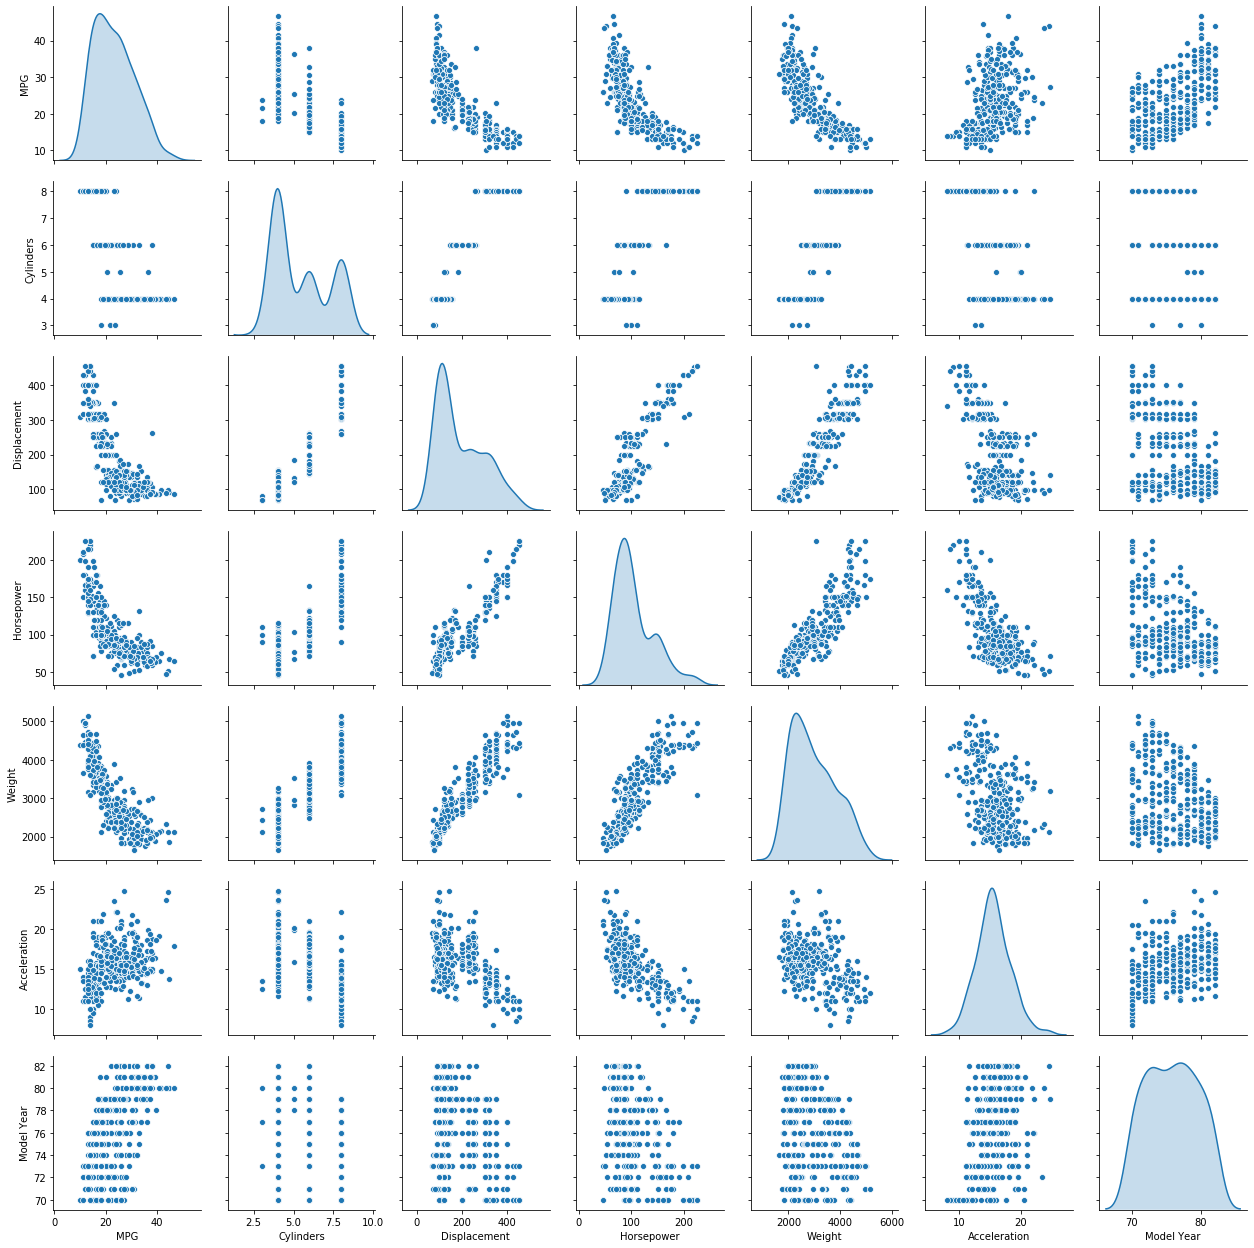

In [30]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year"]], diag_kind="kde")

Look at the overall statistics

In [32]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


# **Split features from labels**


---



Seperate the target value, or "label", from the features. This label is the value that you will train teh valur that you will train the model to predict.


In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')


# **Normalize the data**






In [0]:
def norm(x):
  return (x - train_stats['mean'])/train_stats['std']

normalized_train_data = norm(train_dataset)
normalized_test_data = norm(test_dataset)

Again, look at the overall normalized statistics

In [36]:
normalized_train_stats = normalized_train_data.describe()
normalized_train_stats = normalized_train_stats.transpose()
normalized_train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,2.093159e-16,1.0,-1.457657,-0.869348,-0.869348,1.483887,1.483887
Displacement,314.0,1.018294e-16,1.0,-1.220325,-0.860894,-0.424785,0.675074,2.489002
Horsepower,314.0,-1.909301e-17,1.0,-1.545283,-0.751241,-0.272190,0.607162,3.153347
Weight,314.0,-9.723291e-17,1.0,-1.589352,-0.869478,-0.198782,0.732017,2.547401
Acceleration,314.0,2.688832e-15,1.0,-2.710152,-0.630725,-0.021237,0.588250,3.313017
Model Year,314.0,9.561531e-16,1.0,-1.604642,-0.788458,0.027726,0.843910,1.660094
USA,314.0,6.081476e-17,1.0,-1.286751,-1.286751,0.774676,0.774676,0.774676
Europe,314.0,8.485781e-18,1.0,-0.465148,-0.465148,-0.465148,-0.465148,2.143005
Japan,314.0,3.164489e-17,1.0,-0.495225,-0.495225,-0.495225,-0.495225,2.012852


# **The Model**